In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
from typing import Union,TypeVar
from datetime import datetime

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.TRGAN_main_V2 import *
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *
from TRGAN.TRGAN_light_preprocessing import *
from TRGAN.data_preprocessing import load_data

# import random

# random.seed(55555)
# np.random.seed(55555)


import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
# data = load_data(path='Data/', name='czech')
data = load_data(path='Data/', name='transaction_secret')

In [3]:
data.head()

,CustomerKey,ID,TRANS_TIME,AMOUNT_EQ,MCC,PAY_AMT,PaymentSystem,TERMINAL_CODE,ADDRESS,TRANS_DETAIL,NAME,OpType,DETAILED_CARD_TYPE,IS_OWN_TERMINAL,ACCOUNT_ID,CARD,DATE,HOUR,MINUTE,SECOND
0,1017282,394202930,2024-08-26 00:04:34,3000.0,6011,3000.0,MasterCard,AC090236,"РОССИЯ,197101,,,г Санкт-Петербург,пр-кт Каменн...","KAMENNOOSTROVSKIY, 20, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard Unembossed,True,1445605,2516326,2017-05-01,0,4,34
1,1005525,394373193,2024-08-26 01:53:39,2000.0,6011,2000.0,MasterCard,AC090347,"РОССИЯ,194356,,,г Санкт-Петербург,ул Бухарестс...","BUKHARESTSKAYA,18, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard Unembossed,True,4351563,3005469,2017-05-01,1,53,39
2,1012091,394372678,2024-08-26 05:23:40,200.0,6011,200.0,MasterCard,AC090350,"РОССИЯ,191002,,,г Санкт-Петербург,ул Большая М...","B.MOSKOVSKAYA,2/1, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard Unembossed,True,1437772,328245,2017-05-01,5,23,40
3,1011245,394369261,2024-08-26 06:24:13,400.0,6011,400.0,MasterCard,AC090226,"РОССИЯ,198216,,,г Санкт-Петербург,б-р Новаторо...","NOVATOROV, 1, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard World,True,1812662,2845106,2017-05-01,6,24,13
4,1000235,394372599,2024-08-26 06:36:07,1000.0,5541,1000.0,MasterCard,P7500052,"ул. Красносельская, д. 151","OOO TEK - KALININGRAD, KALININGRAD, RU",Оплата товаров/услуг по карте,Оплата,MasterCard World,True,7690800,2935068,2017-05-01,6,36,7


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
data['HOUR'] = data['TRANS_TIME'].dt.hour
data['MINUTE'] = data['TRANS_TIME'].dt.minute
data['SECOND'] = data['TRANS_TIME'].dt.second
                
onehot_cols = ['MCC', 'OpType', 'NAME', 'PaymentSystem']
cat_feat_names = ['CustomerKey', 'ID', 'TERMINAL_CODE', 'ADDRESS',\
                'TRANS_DETAIL', 'DETAILED_CARD_TYPE', 'IS_OWN_TERMINAL', 'ACCOUNT_ID', 'CARD']

num_feat_names = ['AMOUNT_EQ', 'PAY_AMT', 'HOUR', 'MINUTE', 'SECOND']
log1p_transform_cols = ['AMOUNT_EQ']
date_feature = 'DATE'
time_feature = 'TRANS_TIME'
client_id = 'CustomerKey'
mcc_name = 'MCC'

latent_dim = {'onehot': 20, 'categorical': 6, 'numerical': 6, 'cv': 10}

In [6]:
# cat_feat_names = ['customer']
# onehot_cols = ['mcc']
# num_feat_names = ['amount', 'balance', 'age']
# log1p_transform_cols = ['amount']
# date_feature = 'transaction_date'
# time_feature = 'time'
# client_id = 'customer'
# mcc_name = 'mcc'

# latent_dim = {'onehot': 20, 'categorical': 6, 'numerical': 6, 'cv': 10}

In [6]:
%%time

X_emb, X_oh, cond_vector, synth_date, scaler_cat, scaler_onehot, scaler_num, cv_params = \
                                trgan.embeddings(data, cat_feat_names, num_feat_names, onehot_cols, date_feature, client_id, latent_dim, device=DEVICE, epochs=10)

Loss E_cv: 0.002237126: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]

CPU times: user 4min 14s, sys: 9.75 s, total: 4min 24s
Wall time: 2min 38s


In [7]:
# experiment_id = 'TRGAN_V2_1'
# DIRECTORY = 'Pretrained_model/'
# load = False

In [13]:
%%time

generator, supervisor, loss_array = trgan.train(X_emb, cond_vector, latent_dim, dim_noise=15, epochs=40, load=True)

In [18]:
n_samples = len(X_emb[:]) + 189
synth_data, synth_date, params = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, cv_params['encoder'], data,\
                                date_feature, client_id, cv_params=cv_params, device=DEVICE)

synth_df = inverse_transform(synth_data, latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
                             mcc_name, num_feat_names, True, synth_date, 'TRANS_TIME')

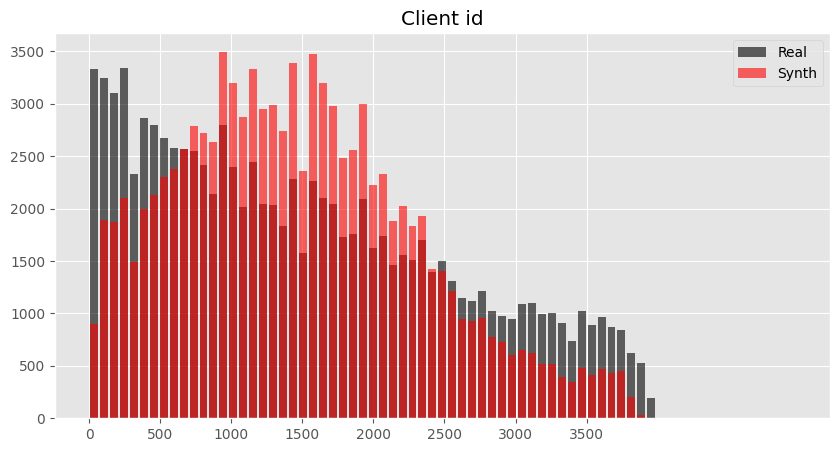

In [19]:
fig, axs = plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(data[client_id], alpha=0.6, label='Real', bins=np.arange(0, 5000, 70), color='black', rwidth=0.8)
plt.hist(synth_df[client_id], alpha=0.6, label='Synth', bins=np.arange(0, 5000, 70), color='red', rwidth=0.8)

plt.legend()
plt.xticks(np.arange(0, len(data[client_id].value_counts()), 500), np.arange(0, len(data[client_id].value_counts()), 500))
plt.title('Client id')

plt.show()

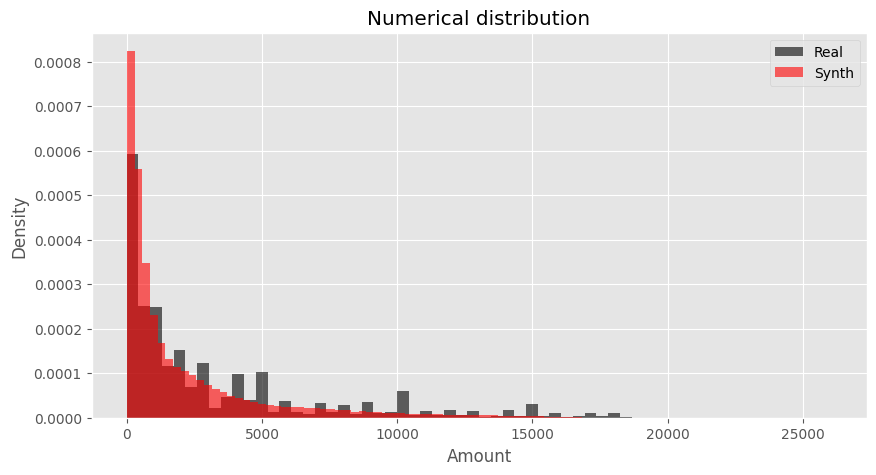

In [16]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(data['AMOUNT_EQ'], bins=60, label='Real', alpha=0.6, density=True, color='black')
plt.hist(synth_df['AMOUNT_EQ'], bins=60, label='Synth', alpha=0.6, density=True, color='red')
# np.arange(0, 12, 0.2)

plt.legend()
plt.title('Numerical distribution')
plt.xlabel('Amount')
plt.ylabel('Density')
plt.show()

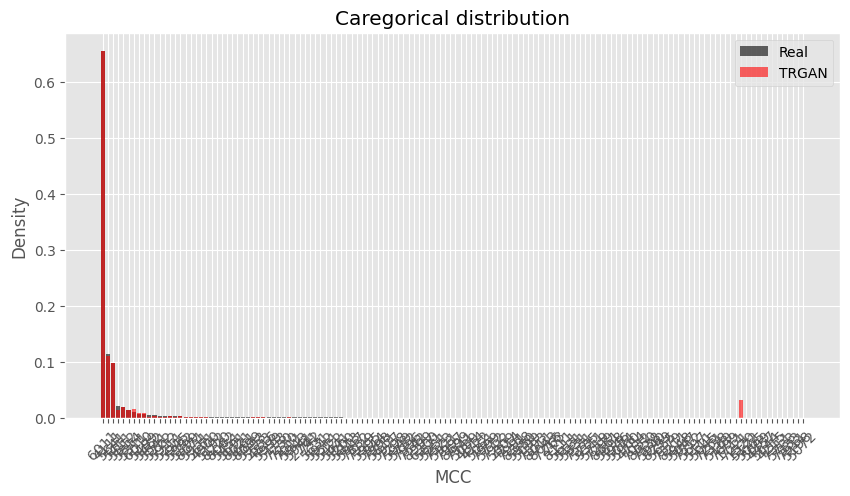

In [17]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.bar(data[mcc_name].value_counts().index.values.astype(int).astype(str), data[mcc_name].value_counts().values/(np.sum(data[mcc_name].value_counts().values)),\
                                                    color='black', alpha=0.6, label='Real')
plt.bar(synth_df[mcc_name].value_counts().index.values.astype(int).astype(str), synth_df[mcc_name].value_counts().values/(np.sum(synth_df[mcc_name].value_counts().values)),\
                                                    color='red', alpha=0.6, label='TRGAN')

plt.xticks(data[mcc_name].value_counts().index.values.astype(str)[::], labels=data[mcc_name].value_counts().index.values.astype(str)[::], rotation=45)
# plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.legend()
plt.title('Caregorical distribution')
plt.ylabel('Density')
plt.xlabel('MCC')
plt.show()